In [1]:
import pandas as pd

ds = pd.read_csv('data/dataset.csv')
ds.head(5)

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


## Data points and classes from dataset that we have

In [2]:
ds.nunique()

id             1225029
url            1225029
landmark_id      14951
dtype: int64

The dataset contains **1,225,029** images that belongs to **14,951** classes. Let say each image take 200KB to download, then it would be more than 244GB! Download all of this dataset would take about a week (24/7 and a stable internet connection). The time for training could take a month (based on my current limiting computational resource). For that reason, I will use only images from about 1% (149 classes) of the total classes and split the training dataset into 75% for training, 25% for validation and testing. I believe 1% of the total classes would be enough to evaluate the solution model with a reasonable training time.

## How about the distribution of data?

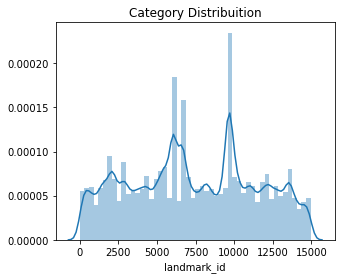

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

plt.figure(figsize = (5, 4))
plt.title('Category Distribuition')
sns.distplot(ds.landmark_id)

plt.show()

In [4]:
ds['landmark_id'].value_counts().describe()

count    14951.000000
mean        81.936258
std        707.234873
min          1.000000
25%          6.000000
50%         14.000000
75%         46.000000
max      50337.000000
Name: landmark_id, dtype: float64

The dataset seem to be imbalanced. The dataset have 14,951 classes but 75% of them have less than 46 images while maximum can be 50,337 images.

## Display some images

In [5]:
from utils import visualization as vs

urls = ds[ds['landmark_id'] == 3]['url']
vs.display_image_from_urls(urls, display_len=10)

By visualize some images, I known that the size of the images in the dataset are different.

## The reduced version of the dataset

In [59]:
total_classes = ds['landmark_id'].nunique()
ix = total_classes // 2  # Median index
nb_classes = total_classes // 100  # number of classes we will use (1% of total classes)
start = ix - (nb_classes // 2)
end = ix + (nb_classes // 2)

# Sort dataset by count the url and get the reduced number of classes in the median range
df = ds[['landmark_id', 'url']].groupby(['landmark_id']).count().sort_values(['url']).reset_index()
df = df.iloc[start: end + 1]

# Filter landmark_id to get the reduced version of data
data = ds[ds['landmark_id'].isin(df['landmark_id'])].reset_index(drop=True)

# Some statistics of the reduced data version
data['landmark_id'].value_counts().describe()

count    149.000000
mean      13.657718
std        0.476074
min       13.000000
25%       13.000000
50%       14.000000
75%       14.000000
max       14.000000
Name: landmark_id, dtype: float64

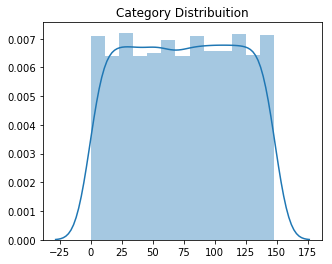

,id,url,landmark_id
0,d5e1bef426a69176,http://lh5.ggpht.com/-GFBOpwH641I/S41MnMfXhxI/...,4944
1,e21e3a1d39b63b83,https://lh6.googleusercontent.com/-xIZDKYsLRAQ...,9570
2,e980ae924c58bcb0,https://lh4.googleusercontent.com/-6I9Bfb3DGP8...,1612
3,386e901ad3f4d42c,https://lh3.googleusercontent.com/-MGpibtQDzH4...,10871
4,eb88ad2dbcfced05,http://mw2.google.com/mw-panoramio/photos/thum...,4920


In [60]:
#ds.groupby(['landmark_id']).count().reset_index().diff().hist()
data.landmark_id = pd.Categorical(data.landmark_id)

plt.figure(figsize = (5, 4))
plt.title('Category Distribuition')
sns.distplot(data.landmark_id.cat.codes)

plt.show()
data.head(5)

The reduced version of the dataset seem to be balanced. Each class contains from 13 to 14 images. Not too much images for training a model. But let see how well my learning model will perform in this dataset.

## Split the reduced version of dataset for training, testing and validating

In [61]:
import numpy as np
import csv
from math import ceil, floor

train = None
valid = None
test = None
for name, group in data.groupby('landmark_id'):
    test_size = int(floor(.1*len(group)))  # 10% for testing
    valid_size = int(ceil(.15*len(group)))  # 15% for validating
    test_, valid_, train_ = np.split(group, [test_size, test_size + valid_size])
    if train is None:
        train, valid, test = (train_, valid_, test_)
    else:
        train = train.append(train_, ignore_index=True)
        valid = valid.append(valid_, ignore_index=True)
        test = test.append(test_, ignore_index=True)
print(len(train), len(valid), len(test))

# Save to csv files
train.to_csv('data/train.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
valid.to_csv('data/valid.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
test.to_csv('data/test.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

1490 396 149


## Download images

In [8]:
from utils.download_data import fetch

fetch('data/train.csv', 'data/train')
fetch('data/valid.csv', 'data/valid')
fetch('data/test.csv', 'data/test')

100%|██████████████████████████████████████████████████████████████████████████████| 1490/1490 [02:06<00:00, 11.77it/s]


Total number of download failures: 7


100%|████████████████████████████████████████████████████████████████████████████████| 396/396 [00:41<00:00,  1.24it/s]


Total number of download failures: 1


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:20<00:00,  1.81s/it]


Total number of download failures: 0
